In [1]:
from gym import spaces
from gym import Env
import gym 
from typing import Tuple, Optional, List, Union

import PIL.Image
import PIL.ImageDraw
import PIL.Image
from gym import logger, spaces
from PIL import ImageFont
from time import time
%matplotlib inline
from collections import defaultdict
import math

import matplotlib.pyplot as plt

from matplotlib import style

from gym.envs.classic_control import utils
import numpy as np
np.set_printoptions(suppress=True)

import json
import random
style.use('dark_background')


In [5]:
MAX_ROT_SPEED = 150

In [211]:
class DrillingEnv(gym.Env[np.ndarray, Union[int, np.ndarray]]):
  def __init__(self, max_steps):
    high = np.array(
            [
               200
            ],
            dtype=np.int32,
        )
    self.action_space = spaces.Discrete(3)
    self.observation_space = spaces.Box(np.array([0], dtype = np.int32), high, dtype=np.int32)
    self.state = None
    self.steps_beyond_terminated = None
    self.max_steps = max_steps
    self.step_session = 0
  def step(self, action):
    self.step_session += 1
    RPM = self.state
    if action == 0:
      action_rot = 1
    elif action == 1:
     action_rot = -1
    else:
      action_rot = 0
    # 1 -> вправо 
    # 0 -> влево  
    RPM_new = RPM +  action_rot * 2
    self.state = (int(RPM_new))
    RPM_optimal_upper = 120
    RPM_optimal_lower = 105
    terminated = bool(
            RPM_new > MAX_ROT_SPEED * 0.8
            or RPM_new < MAX_ROT_SPEED * 0.7
        )
    if not terminated and self.step_session < self.max_steps and RPM_new != RPM:
      reward = 2
    elif not terminated and RPM_new == RPM:
      reward = 3
    elif not terminated:
      reward = 1
    elif terminated and (RPM_optimal_lower - RPM_new) < (RPM_optimal_lower - RPM):
      reward = 0.5
    elif self.step_session < self.max_steps:
      reward = 0
    else:
      reward = 0

    return np.array(self.state, dtype=np.int32), reward, terminated, False
  def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):  
        self.step_session = 0
        RPM = MAX_ROT_SPEED * 0.4
        self.state = np.array([int(RPM)])
        return np.array(self.state, dtype=np.int32)
  def render(self):
      if self.render_mode is None:
          gym.logger.warn(
              "You are calling render method without specifying any render mode. "
              "You can specify the render_mode at initialization, "
              f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
          )
          return

In [215]:
env = DrillingEnv(25)
state = env.reset()
print(f'Количество действий : {env.action_space.n}')
print(f'Оптимальные обороты: от {MAX_ROT_SPEED * 0.7} до {MAX_ROT_SPEED * 0.8}')
print(f'Начальное состояние: \n \
Обороты : {state[0]}')
s, r, done, _  = env.step(env.action_space.sample())
print(f'Случайное состояние и случайная награда после шага: {s}, {r}')

Количество действий : 3
Оптимальные обороты: от 105.0 до 120.0
Начальное состояние: 
 Обороты : 60
Случайное состояние и случайная награда после шага: 58, 0


In [202]:
env = DrillingEnv(max_steps = 15)
env.reset()
rpm_session = []
r_session = []
for _ in range(30):
  s, r, done, _ = env.step(env.action_space.sample())
  rpm_session.append(s)
  r_session.append(r)
  # if done == False:
  #   print('yep')
  #   break

### Обучение

In [203]:
class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        n_state = int(state)
        return self._qvalues[n_state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        n_state = int(state)
        self._qvalues[n_state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0
        value = -float('inf')
        for action in possible_actions: 
          q_value = self.get_qvalue(state, action)
          if q_value > value:
            value = q_value
        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        q_value = (1 - learning_rate) * self.get_qvalue(state, action) + learning_rate * (reward + gamma * self.get_value(next_state))

        self.set_qvalue(state, action, q_value)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        qvalue = -float('inf')
        best_action = None
        for action in possible_actions:
          new_qvalue = self.get_qvalue(state, action)
          if qvalue < new_qvalue:
            qvalue = new_qvalue
            best_action = action

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        chosen_action = None

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon
        if epsilon > random.uniform(0, 1):
          chosen_action = random.choice(possible_actions)
        else:
          chosen_action = self.get_best_action(state)

        return chosen_action

In [204]:
def play_and_train(env, agent, t_max=10**3):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)

        # train (update) agent for state s
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
    return total_reward
     

In [205]:
n_actions = 3
agent = QLearningAgent(alpha=0.2, epsilon=0.25, discount=0.99,
                       get_legal_actions=lambda s: range(n_actions))


In [207]:
env = DrillingEnv(50)

In [208]:
rewards = []
for i in range(10000):
  agent.epsilon *= 0.99
  rewards.append(play_and_train(env, agent))
  agent.epsilon *= 0.99
  if i % 1000 == 0:
    print('Средняя награда: ', np.array(rewards).mean())
  if i % 2000 == 0:
    print('epsilon: ', agent.epsilon)  

Средняя награда:  299.0
epsilon:  0.245025
Средняя награда:  2879.2357642357642
Средняя награда:  2933.1479260369815
epsilon:  8.511160651401826e-19
Средняя награда:  2951.15044985005
Средняя награда:  2960.1709572606846
epsilon:  2.9564271251492917e-36
Средняя награда:  2965.5533893221354
Средняя награда:  2969.1943842692885
epsilon:  1.0269411780964239e-53
Средняя награда:  2971.7770318525927
Средняя награда:  2973.6769153855766
epsilon:  3.5671712463293677e-71
Средняя награда:  2975.192423064104


In [135]:
env = DrillingEnv(25)
s = env.reset()
RMP_session = []
for t in range(200):
    # get agent to pick action given state s.
    a = agent.get_action(s)
    next_s, r, done, _ = env.step(a)
    # train (update) agent for state s
    agent.update(s, a, r, next_s)
    s = next_s
    RMP_session.append(s)

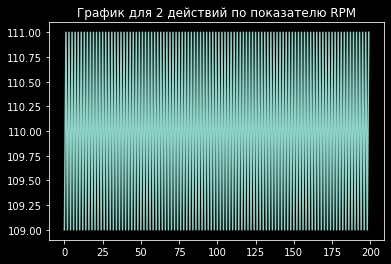

In [143]:
plt.plot(RMP_session)
plt.title('График для 2 действий по показателю RPM'); # минусы - сильные колебания

In [179]:
env = DrillingEnv(25)
s = env.reset()
RMP_session = []
for t in range(200):
    # get agent to pick action given state s.
    a = agent.get_action(s)
    next_s, r, done, _ = env.step(a)
    # train (update) agent for state s
    agent.update(s, a, r, next_s)
    s = next_s
    RMP_session.append(s)

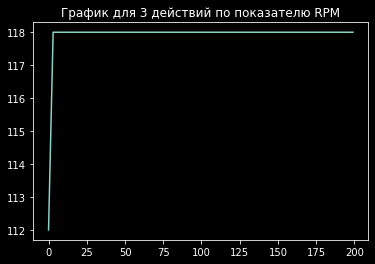

In [180]:
plt.plot(RMP_session)
plt.title('График для 3 действий по показателю RPM'); # минусы - изначально находимся в оптимуме

In [209]:
env = DrillingEnv(25)
s = env.reset()
RMP_session = []
for t in range(200):
    # get agent to pick action given state s.
    a = agent.get_action(s)
    next_s, r, done, _ = env.step(a)
    # train (update) agent for state s
    agent.update(s, a, r, next_s)
    s = next_s
    RMP_session.append(s)

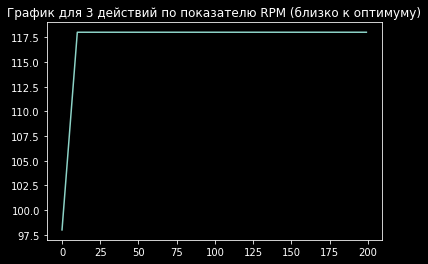

In [212]:
plt.plot(RMP_session)
plt.title('График для 3 действий по показателю RPM (близко к оптимуму)'); # минусы - существует подсказка по оптимуму

In [216]:
n_actions = 3
agent = QLearningAgent(alpha=0.2, epsilon=0.25, discount=0.99,
                       get_legal_actions=lambda s: range(n_actions))
env = DrillingEnv(50)

In [217]:
rewards = []
for i in range(10_000):
  agent.epsilon *= 0.99
  rewards.append(play_and_train(env, agent))
  agent.epsilon *= 0.99
  if i % 1000 == 0:
    print('Средняя награда: ', np.array(rewards).mean())
  if i % 2000 == 0:
    print('epsilon: ', agent.epsilon)  

Средняя награда:  283.0
epsilon:  0.245025
Средняя награда:  2863.8996003996003
Средняя награда:  2903.430034982509
epsilon:  8.511160651401826e-19
Средняя награда:  2916.6156281239587
Средняя награда:  2923.2100724818797
epsilon:  2.9564271251492917e-36
Средняя награда:  2927.167266546691
Средняя награда:  2929.8056157307115
epsilon:  1.0269411780964239e-53
Средняя награда:  2931.690258534495
Средняя награда:  2933.1037995250595
epsilon:  3.5671712463293677e-71
Средняя награда:  2934.2032551938673


In [218]:
env = DrillingEnv(25)
s = env.reset()
RMP_session = []
for t in range(200):
    # get agent to pick action given state s.
    a = agent.get_action(s)
    next_s, r, done, _ = env.step(a)
    # train (update) agent for state s
    agent.update(s, a, r, next_s)
    s = next_s
    RMP_session.append(s)

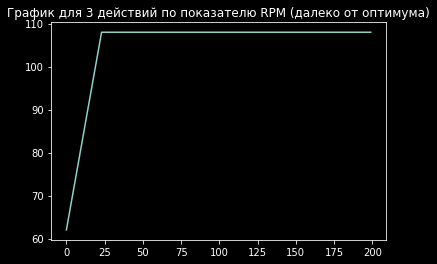

In [219]:
plt.plot(RMP_session)
plt.title('График для 3 действий по показателю RPM (далеко от оптимума)'); # минусы - существует подсказка по оптимуму